In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


(X_train_val_unscaled, y_train_val), (X_test_unscaled, y_test) = tf.keras.datasets.mnist.load_data()
type(y_test)

numpy.ndarray

In [2]:
### Preprocessing - 50k/10k/10k train/val/test ###

# Scale pixel values to b/w 0 and 1
X_train_val = (X_train_val_unscaled / 255).astype(np.float32)
X_test = (X_test_unscaled / 255).astype(np.float32)

# Shuffle + stratified split the 60k X_train_val into 50k/10k X_train/X_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Print info on the preprocessed data
print(f'Train: num_samples={len(X_train)} | priors={dict(sorted(Counter(y_train).items()))}')
print(f'Val: num_samples={len(X_val)} | priors={dict(sorted(Counter(y_val).items()))}')
print(f'Test: num_samples={len(X_test)} | priors={dict(sorted(Counter(y_test).items()))}')

Train: num_samples=48000 | priors={0: 4738, 1: 5394, 2: 4766, 3: 4905, 4: 4674, 5: 4337, 6: 4734, 7: 5012, 8: 4681, 9: 4759}
Val: num_samples=12000 | priors={0: 1185, 1: 1348, 2: 1192, 3: 1226, 4: 1168, 5: 1084, 6: 1184, 7: 1253, 8: 1170, 9: 1190}
Test: num_samples=10000 | priors={0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [3]:
### Train the baseline model ###

MAX_EPOCHS = 200
BATCH_SIZE = 64

input_size = (28, 28)
output_size = 10

num_hidden_layers = 2
hidden_layer_size = 64
activation='relu'
learning_rate = 0.0002
l2_strength = 0.0005
dropout_rate = 0.3

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))
model.add(tf.keras.layers.Flatten())
for _ in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            hidden_layer_size,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
        )
    )
    # Dropout layer after each Dense layer
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/200
750/750 - 2s - 3ms/step - accuracy: 0.6555 - loss: 1.1634 - val_accuracy: 0.8872 - val_loss: 0.4996
Epoch 2/200
750/750 - 1s - 1ms/step - accuracy: 0.8437 - loss: 0.6080 - val_accuracy: 0.9169 - val_loss: 0.3767
Epoch 3/200
750/750 - 1s - 2ms/step - accuracy: 0.8783 - loss: 0.4956 - val_accuracy: 0.9263 - val_loss: 0.3319
Epoch 4/200
750/750 - 1s - 1ms/step - accuracy: 0.8941 - loss: 0.4419 - val_accuracy: 0.9340 - val_loss: 0.3047
Epoch 5/200
750/750 - 1s - 1ms/step - accuracy: 0.9054 - loss: 0.4051 - val_accuracy: 0.9393 - val_loss: 0.2819
Epoch 6/200
750/750 - 1s - 1ms/step - accuracy: 0.9125 - loss: 0.3833 - val_accuracy: 0.9429 - val_loss: 0.2695
Epoch 7/200
750/750 - 1s - 1ms/step - accuracy: 0.9203 - loss: 0.3576 - val_accuracy: 0.9456 - val_loss: 0.2567
Epoch 8/200
750/750 - 1s - 1ms/step - accuracy: 0.9249 - loss: 0.3386 - val_accuracy: 0.9487 - val_loss: 0.2481
Epoch 9/200
750/750 - 1s - 1ms/step - accuracy: 0.9283 - loss: 0.3245 - val_accuracy: 0.9520 - val_loss:

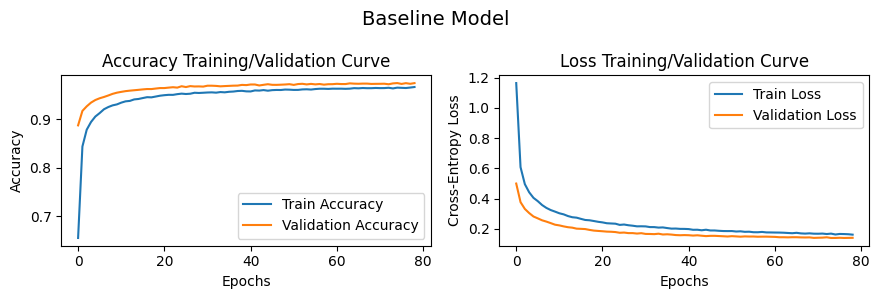

Final Results after 79 epochs:
Accuracy: Train=96.61% | Val=97.41%
Loss: Train=0.1620 | Val=0.1410


In [4]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Losses plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].legend()

# Show plots
fig.suptitle('Baseline Model', fontsize=14)
plt.tight_layout()
plt.show()

print(f'Final Results after {len(history.history['accuracy'])} epochs:')
print(f'Accuracy: Train={history.history['accuracy'][-1] * 100:.2f}% | Val={history.history['val_accuracy'][-1] * 100:.2f}%')
print(f'Loss: Train={history.history['loss'][-1]:.4f} | Val={history.history['val_loss'][-1]:.4f}')